In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from __future__ import annotations
from typing import Tuple, List

In [6]:
df = pd.read_excel('Datos/Aldebaran_pepsi.xlsx', sheet_name='Aldebaran_pepsi')
df.to_csv('Datos/Aldebaran_pepsi.csv', index=False)
iron = pd.read_excel('Datos/Moore.xlsx', sheet_name='Hoja1')
iron.to_csv('Datos/Moore.csv', index=False)

In [20]:
import numpy as np
import pandas as pd


class InputDataError(ValueError):
    """Error para condiciones inválidas en los datos de entrada."""
    pass


def _check_inputs(x: np.ndarray, y: np.ndarray) -> None:
    """
    Verifica (sin modificar) que x e y sean arreglos 1D de igual longitud, sin NaNs,
    y que x sea estrictamente creciente. No reordena ni altera los datos.
    """
    if x is None or y is None:
        raise InputDataError("x e y no pueden ser None.")
    x = np.asarray(x)
    y = np.asarray(y)
    if x.ndim != 1 or y.ndim != 1:
        raise InputDataError("x e y deben ser 1D.")
    if x.size != y.size:
        raise InputDataError("x e y deben tener la misma longitud.")
    if np.any(~np.isfinite(x)) or np.any(~np.isfinite(y)):
        raise InputDataError("x e y no deben contener NaN o infinitos.")
    # x estrictamente creciente (sin ordenar)
    if not np.all(np.diff(x) > 0):
        raise InputDataError(
            "x debe ser estrictamente creciente (monótona) y no será reordenado.\n"
            "Ordena tus datos externamente si es necesario."
        )


def detect_discrete_minima_candidates(y: np.ndarray) -> np.ndarray:
    """
    Devuelve los índices i que cumplen la condición discreta de mínimo local:
        y[i-1] > y[i] < y[i+1]
    No aplica ningún filtrado ni umbral.
    """
    y = np.asarray(y)
    if y.size < 3:
        return np.array([], dtype=int)
    cond = (y[1:-1] < y[0:-2]) & (y[1:-1] < y[2:])
    return np.nonzero(cond)[0] + 1


def _fit_poly_and_refine_min(x_win, y_win, degree, x_center):
    coeffs = np.polyfit(x_win, y_win, deg=degree)
    p = np.poly1d(coeffs)
    dp = p.deriv(1)
    d2p = p.deriv(2)

    roots = np.roots(dp)
    roots = roots[np.isclose(roots.imag, 0, atol=1e-12)].real

    if len(roots) == 0:
        return np.nan, np.nan, False, False, np.nan

    x_min, x_max = x_win.min(), x_win.max()
    roots = roots[(roots >= x_min) & (roots <= x_max)]
    if len(roots) == 0:
        return np.nan, np.nan, False, False, np.nan

    # Elegir la raíz más cercana al candidato discreto
    x_star = roots[np.argmin(np.abs(roots - x_center))]
    y_star = p(x_star)
    curvature = d2p(x_star)  # segunda derivada
    is_min = curvature > 0

    return float(x_star), float(y_star), True, bool(is_min), float(curvature)


def find_local_minima_polyfit(
    x: np.ndarray,
    y: np.ndarray,
    window_pts: int = 15,
    degree: int = 4,
    min_points: int = None,
    min_curvature: float = 100,
) -> pd.DataFrame:
    """
    Encuentra y refina mínimos locales usando un ajuste polinómico local.
    NO modifica x ni y.

    Parámetros
    ----------
    x, y : arrays 1D
        Datos originales. x debe ser estrictamente creciente; no se reordena.
    window_pts : int, default 15
        Número de puntos usados por ventana local (idealmente 10–20).
    degree : int, default 4
        Grado del polinomio local.
    min_points : int, default None
        Mínimo de puntos exigidos para el ajuste.
    min_curvature : float, default 0.0
        Umbral mínimo para la segunda derivada. 
        Filtra mínimos "planos": solo se aceptan si d²p(x_refined) >= min_curvature.

    Retorna
    -------
    pandas.DataFrame con columnas:
        - idx_candidate : índice detectado por la prueba discreta
        - x_refined     : posición refinada del mínimo
        - y_refined     : valor del polinomio en x_refined
        - curvature     : segunda derivada en el mínimo
        - valid_minimum : True si es un mínimo local con curvatura >= min_curvature
    """
    _check_inputs(x, y)

    if window_pts < degree + 1:
        raise ValueError("window_pts debe ser al menos degree+1.")
    if min_points is None:
        min_points = degree + 1
    if min_points < degree + 1:
        raise ValueError("min_points debe ser >= degree+1.")

    n = len(x)
    half = window_pts // 2

    candidates = detect_discrete_minima_candidates(y)
    rows = []

    for i in candidates:
        start = max(0, i - half)
        end = min(n, start + window_pts)
        start = max(0, end - window_pts)

        x_win = x[start:end]
        y_win = y[start:end]

        if x_win.size < min_points:
            rows.append({
                "idx_candidate": int(i),
                "x_refined": np.nan,
                "y_refined": np.nan,
                "curvature": np.nan,
                "degree": degree,
                "window_start": int(start),
                "window_end": int(end),
                "num_points": int(x_win.size),
                "root_in_window": False,
                "valid_minimum": False,
            })
            continue

        try:
            x_star, y_star, root_in_window, is_min, curvature = _fit_poly_and_refine_min(
                x_win, y_win, degree, x_center=x[i]
            )
        except np.linalg.LinAlgError:
            x_star, y_star, root_in_window, is_min, curvature = np.nan, np.nan, False, False, np.nan

        # Aplicar filtro de curvatura
        valid = bool(is_min and curvature >= min_curvature)

        rows.append({
            "idx_candidate": int(i),
            "x_refined": x_star,
            "y_refined": y_star,
            "curvature": curvature,
            "degree": degree,
            "window_start": int(start),
            "window_end": int(end),
            "num_points": int(x_win.size),
            "root_in_window": bool(root_in_window),
            "valid_minimum": valid,
        })

    return pd.DataFrame(rows)


In [26]:
df = pd.read_csv('Datos/Aldebaran_pepsi.csv')

x = df.iloc[:,0]  # primera columna
y = df.iloc[:,1]  # segunda columna


df_min = find_local_minima_polyfit(x, y, window_pts=15, degree=2)

print(df_min.head())



   idx_candidate    x_refined  y_refined   curvature  degree  window_start  \
0             12  3950.153506   0.833435  -21.630095       2             5   
1             14  3950.150971   0.825138  -11.604489       2             7   
2             39  3950.356990   0.262190  130.259100       2            32   
3             65          NaN        NaN         NaN       2            58   
4             88  3950.779558   0.964729   49.585867       2            81   

   window_end  num_points  root_in_window  valid_minimum  
0          20          15            True          False  
1          22          15            True          False  
2          47          15            True           True  
3          73          15           False          False  
4          96          15            True          False  


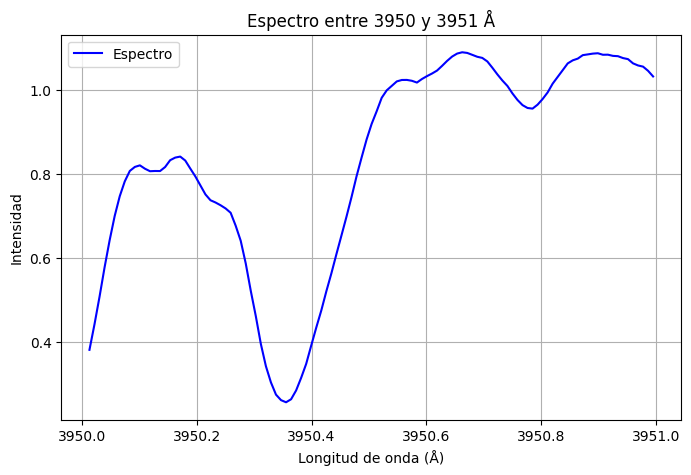

In [22]:
## Hacer un gráfico del espectro entre dos valores específicos de longitud de onda

x1 = 3950
x2 = 3951

mask = (x >= x1) & (x <= x2)
x_range = x[mask]
y_range = y[mask]

# Graficar
plt.figure(figsize=(8, 5))
plt.plot(x_range, y_range, label="Espectro", color="blue")

plt.xlabel("Longitud de onda (Å)")
plt.ylabel("Intensidad")
plt.title("Espectro entre 3950 y 3951 Å")
plt.legend()
plt.grid(True)
plt.show()

In [33]:
# Tolerancia
tol = 0.05

# Crear lista para almacenar matches
matches = []

for i, theo in enumerate(iron.iloc[:,0]):  # recorremos las líneas teóricas
    # Filtrar mínimos observados que estén cerca de la línea teórica
    nearby = df_min[(df_min["x_refined"].notna()) & 
                    (abs(df_min["x_refined"] - theo) <= tol)]
    
    for _, obs in nearby.iterrows():
        matches.append({
            "lambda_theo": theo,                 # línea teórica (Fe I/II)
            "lambda_obs": obs["x_refined"],      # longitud observada en el espectro
            "y_obs": obs["y_refined"],           # intensidad observada
            "delta": obs["x_refined"] - theo     # diferencia entre observado y teórico
        })

# Pasar a dataframe
df_matches = pd.DataFrame(matches)

print(df_matches)


     lambda_theo   lambda_obs     y_obs     delta
0       4067.280  4067.284549  0.090959  0.004549
1       4079.843  4079.800973  0.102160 -0.042027
2       4085.013  4085.007630  0.148476 -0.005370
3       4087.101  4087.104188  0.182082  0.003188
4       4089.224  4089.207149  0.222946 -0.016851
..           ...          ...       ...       ...
549     9013.980  9013.976395  0.485857 -0.003605
550     9019.740  9019.736116  0.813363 -0.003884
551     9036.750  9036.743729  0.936508 -0.006271
552     9084.180  9084.191860  0.812710  0.011860
553     9103.635  9103.628309  0.741945 -0.006691

[554 rows x 4 columns]


In [31]:
c = 299792.458

df_matches["velocity_kms"] = c * (df_matches["delta"]) / df_matches["lambda_theo"]

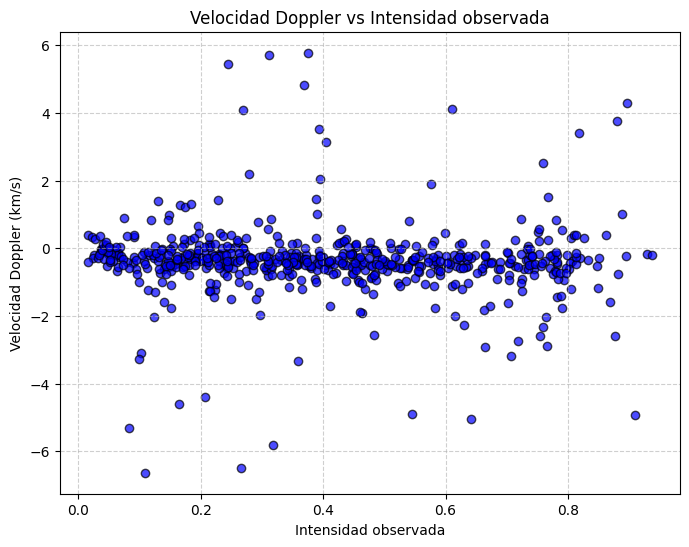

In [32]:
plt.figure(figsize=(8,6))
plt.scatter(df_matches['y_obs'], df_matches['velocity_kms'], color='blue', alpha=0.7, edgecolor='k')

# Etiquetas y título
plt.xlabel("Intensidad observada")
plt.ylabel("Velocidad Doppler (km/s)")
plt.title("Velocidad Doppler vs Intensidad observada")

# Grid y despliegue
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()